In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import time

In [311]:
mpl.rcParams['figure.dpi'] = 150

In [172]:
# arr = np.load('/home/vrabel/EUSO-Balloon/SPBDATA/some_files_node15/spb_simu/simu.2017-07-17-18h52m43s/npyconv/ev_45_mc_1__signals_p128_a0_g30_f128_b20170427-105115-001.001_k1_s0_d32_n21_m128.npy')
# im = np.maximum.reduce(arr)
im = np.random.poisson(3,size=(48,48))

In [86]:
def _rho_cor(phi,unit_len=1):
    phi_rot = (phi-np.pi/4) % np.pi
    if phi_rot < np.pi/2:
        return unit_len/np.abs(2*np.sin(phi))
    else:
        return unit_len/np.abs(2*np.cos(phi))

In [507]:
import collections

def _calc_line_coords(phi, rho, width, height, return_none_val=None):
    p = np.zeros((2,2))
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
#     print('phi={} rho={}'.format(phi, rho))
    if np.abs(sin_phi) > 1e-11:
        if np.abs(cos_phi) > 1e-11:
            tan_phi = sin_phi/cos_phi
            p[0,0] = rho / sin_phi # - 0/tan_phi
            p[0,1] = 0
            p[1,0] = rho / sin_phi - width / tan_phi
            p[1,1] = width
#             print('--1------------')
#             print(p)
#             print('--------------')
            
            for i in range(len(p)):
                if p[i,0] > height:
                    p[i,1] = (rho/sin_phi - height) * tan_phi
                    p[i,0] = height
                elif p[i,0] < 0:
                    p[i,1] = (rho/sin_phi - 0) * tan_phi
                    p[i,0] = 0
        else:
            p[0,0] = rho
            p[0,1] = 0
            p[1,0] = rho
            p[1,1] = width
    else:
        p[0,0] = height
        p[0,1] = rho
        p[1,0] = 0
        p[1,1] = rho
#     print('--F------------')
#     print(p)
#     print('--------------')
    for i in range(len(p)):
        if p[i,0] > height or p[i,0] < 0 or p[i,1] > width or p[i,1] < 0:
            return return_none_val
    
    return p

def _key_vals2val_keys(in_dict, exclusive=False):
    out_dict = {}
    for k,l in in_dict.items():
        for v in l:
            if exclusive:
                out_dict[v] = k
            else:
                if v not in out_dict:
                    out_dict[v] = []
                out_dict[v].append(v)
    return out_dict

def _translate_struct(struct, trans_func):
    """
    Maps all Tasks in a structured data object to their .output().
    """
    if isinstance(struct, (dict, collections.OrderedDict)):
        r = type(struct)()
        for k, v in struct.items():
            r[k] = _translate_struct(v, trans_func)
        return r
    elif isinstance(struct, (list, tuple)):
        try:
            s = list(struct)
        except TypeError:
            raise Exception('Cannot map %s to list' % str(struct))
        return [_translate_struct(r, trans_func) for r in s]

    return trans_func(struct)


def draw_watermark(fig, watermark):
    if not watermark or not fig:
        return
    # fig.text(0, 0, watermark, fontsize=5, color='gray', ha='left', va='top', alpha=.5)
    fig.text(.01, .99, watermark, fontsize=6, color='gray', ha='left', va='top', alpha=1)
    # fig.text(0.95, 0.05, watermark, fontsize=10, color='gray', ha='right', va='bottom', alpha=.5)


In [515]:
def visualize_hough_lines(image, lines, title=None, value_lines_groups=None, exp_tree=None, l1trg_events=None,
                          xlabel="x [pixel]", ylabel="y [pixel]", zlabel="max number of counts within the window",
                          value_lines_colorbar_label='Num. of normalized counts for the line',
                          save_fig_pathname=None, watermark=None, fig_dimensions=(8, 8),
                          skip_zero_value_line_group=True,
                          pmt_width_overwrite=None, pmt_height_overwrite=None,
                          pmt_count_x_overwrite=None, pmt_count_y_overwrite=None,
                          extra_lines=None, trigg_alpha=0.3, line_alpha=None,
                          lines_colormap_name='cool', extra_lines_colormap_name='brg',
                          do_extra_lines_legend=True, extra_line_labels=[], extra_lines_legend_ncol=4,
                          gridspec_height_ratios=(20, 1, 1), gridspec_hspace=.4,
                          do_pixel_centering=False, savefig_info_out_file=None):
    do_extra_lines_legend = do_extra_lines_legend and extra_lines and isinstance(extra_lines, (list, tuple)) and len(extra_lines) > 0
    fig = None
    ax2 = None
    lines_colors = None
    if value_lines_groups is not None and len(value_lines_groups) > 1:
        # value_lines_groups_cpy = collections.OrderedDict(value_lines_groups)
        value_lines_groups_keys = value_lines_groups.keys()
        if skip_zero_value_line_group:
            value_lines_groups_keys = [k for k in value_lines_groups.keys() if k > 0]
        if len(value_lines_groups_keys) > 1:
            cmap = plt.get_cmap(lines_colormap_name)
            max_key = max(value_lines_groups_keys)
            min_key = min(value_lines_groups_keys)
            line_values = _key_vals2val_keys(value_lines_groups, exclusive=True)
            lines_colors = _translate_struct(line_values, lambda v: cmap(float(v - min_key) / float(max_key - min_key)))

            gridspec_nrows = 2
            if do_extra_lines_legend:
                gridspec_nrows += 1

            gs = mpl.gridspec.GridSpec(gridspec_nrows, 1, hspace=.4,
                                       height_ratios=gridspec_height_ratios[:gridspec_nrows])
            fig = plt.figure()
            ax1 = plt.subplot(gs[0])
            ax2 = plt.subplot(gs[1])
            ax3 = None
            if do_extra_lines_legend:
                ax3 = plt.subplot(gs[2])

            norm = mpl.colors.Normalize(vmin=min_key, vmax=max_key)
            cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, orientation='horizontal')
            cb1.set_label(value_lines_colorbar_label)

    if not fig:
        if do_extra_lines_legend:
            gs = mpl.gridspec.GridSpec(2, 1, hspace=gridspec_hspace,
                                       height_ratios=(gridspec_height_ratios[0],gridspec_height_ratios[-1]))
            fig = plt.figure()
            ax1 = plt.subplot(gs[0])
            ax3 = plt.subplot(gs[1])
        else:
            fig, ax1 = plt.subplots(1)

    cax4 = ax1.imshow(image, extent=[0, image.shape[1], image.shape[0], 0])

    if exp_tree:
        draw_pmts(ax1, exp_tree,
                  pmt_width_overwrite=pmt_width_overwrite, pmt_height_overwrite=pmt_height_overwrite,
                  pmt_count_x_overwrite=pmt_count_x_overwrite, pmt_count_y_overwrite=pmt_count_y_overwrite)

    if l1trg_events:
        draw_l1trg_events(ax1, l1trg_events, alpha=trigg_alpha)

    if title:
        ax1.set_title(title)  # "Hough input img (phi normalization)"
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)

    fig.colorbar(cax4, ax=ax1, label=zlabel)

    if line_alpha is None:
        # line_alpha = (0.7*10)/len(lines)
        # a = (0.6 - 0.7) / 10 # == -0.01
        # b = 0.7 - a * 10 # == 0.7 - ((0.6-0.7)/10)*10 # == 0.8
        # line_alpha = max(a*len(lines)+b, 0.15)
        line_alpha = max(-0.01*len(lines) + 0.8, 0.15)

    for line in lines:
        if do_pixel_centering:
            p = _calc_line_coords(line[1], line[0], image.shape[1] - 0.9999, image.shape[0] - 0.9999)
            if p is None:
                continue
            # p[,{y,x}]
            # centering coords to middle of pixels
            for i in range(len(p)):  # iterate over points
                if p[i, 0] + 0.5 <= image.shape[0] and p[i, 1] + 0.5 <= image.shape[1]:
                    p[i, 0] += 0.5
                    p[i, 1] += 0.5
                else:
                    raise RuntimeError('Unexpected line position')
        else:
            p = _calc_line_coords(line[1], line[0], image.shape[1], image.shape[0])
            if p is None:
                continue

        if np.allclose(p[0], p[1]):
            marker_char = '.'
        else:
            marker_char = '-'

        if lines_colors is not None and tuple(line) in lines_colors:
            ax1.plot((p[:, 1]), (p[:, 0]), marker_char, color=lines_colors[tuple(line)], alpha=line_alpha)
            # line_values[line]/max_key)
        else:
            ax1.plot((p[:, 1]), (p[:, 0]), marker_char + 'r', alpha=line_alpha)

    if extra_lines:
        extra_lines_colormap = plt.get_cmap(extra_lines_colormap_name)  # 'autumn'
        colors = [extra_lines_colormap(each) for each in np.linspace(0, 1, len(extra_lines))]
        plots = [None]*len(extra_lines)
        for li, (line, color) in enumerate(zip(extra_lines, colors)):
            # p = proc.calc_line_coords(line[1], line[0], image.shape[1], image.shape[0])
            if do_pixel_centering:
                p = _calc_line_coords(line[1], line[0], image.shape[1] - 0.9999, image.shape[0] - 0.9999)
                if p is None:
                    continue
                for i in range(len(p)):  # iterate over points
                    if p[i, 0] + 0.5 <= image.shape[0] and p[i, 1] + 0.5 <= image.shape[1]:
                        p[i, 0] += 0.5
                        p[i, 1] += 0.5
                    else:
                        raise RuntimeError('Unexpected line position')
            else:
                p = _calc_line_coords(line[1], line[0], image.shape[1], image.shape[0])
                if p is None:
                    continue
            plot, = ax1.plot((p[:, 1]), (p[:, 0]), ':', color=color)
            plots[li] = plot
        # endfor
        if do_extra_lines_legend:  # and ax3:
            if extra_line_labels is None:
                extra_line_labels = []
            labels = []
            notnull_plots = []
            for i, (line, plot) in enumerate(zip(extra_lines, plots)):
                if plot is None:
                    continue
                if i < len(extra_line_labels):
                    labels.append(extra_line_labels[i])
                else:
                    labels.append("({:.2f}, {:.2f})".format(*line))
                notnull_plots.append(plot)
            ax3.legend(notnull_plots, labels, loc='center', mode='expand', frameon=False, borderaxespad=0, borderpad=0,
                       ncol=extra_lines_legend_ncol)
            ax3.set_axis_off()
        # if ax3 ... # legend # TODO

    if fig:  # in next version allow for custom axes
        fig.set_size_inches(fig_dimensions[0], fig_dimensions[1], forward=True)
        draw_watermark(fig, watermark)
        if save_fig_pathname:
            fig.savefig(save_fig_pathname)
            if savefig_info_out_file:
                print('Saved hough lines figure at "{}"'.format(save_fig_pathname), file=savefig_info_out_file)

    return fig, (ax1, ax2)

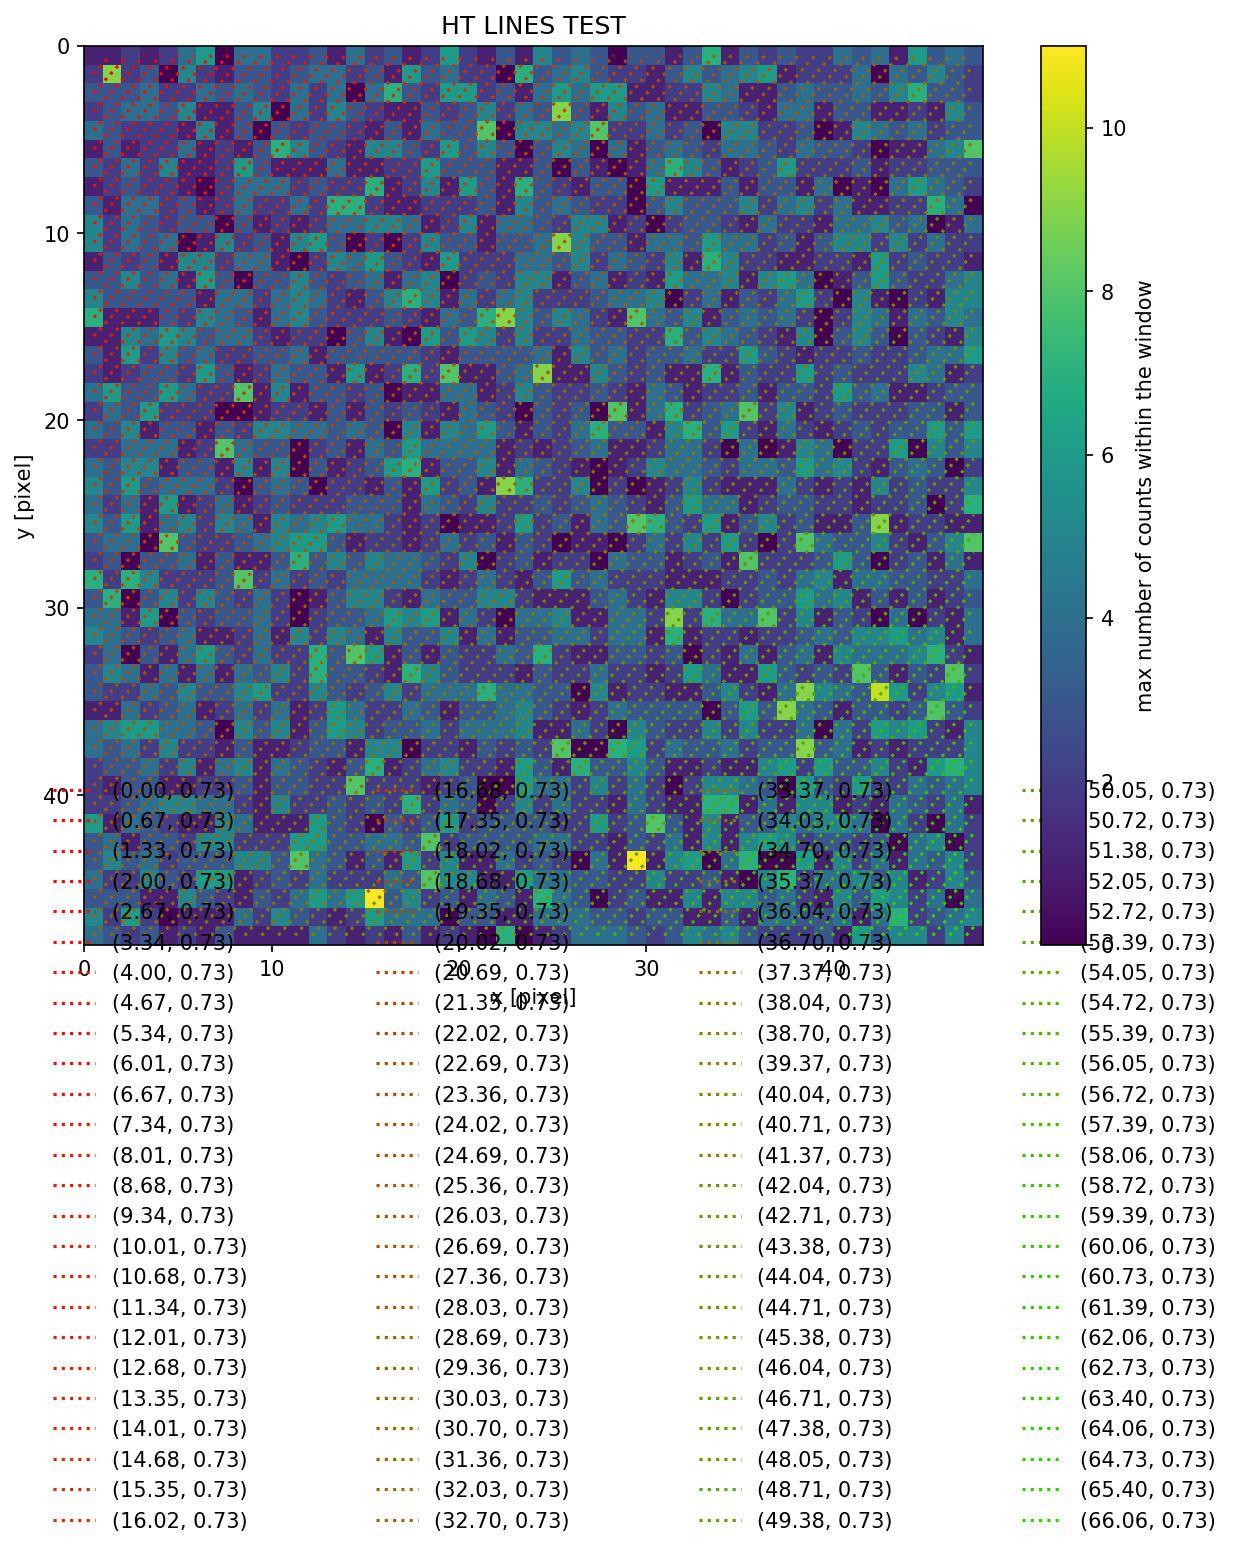

In [516]:

# lines = [ (np.hypot(48,48)/2 -20*np.sqrt(2), np.pi*p/8) for p in range(0,3)  ] # [ (40,i) for i in np.arange(0,np.pi+.05,.05) ] # range(0,49)  # (10,np.pi/150),  (20,np.pi/3),
# lines = [(i*np.sqrt(2)+_rho_cor(np.pi/4), np.pi/4) for i in range(0,47)] #+ [  (0,3*np.pi/4) ]
# lines = [(i*np.sqrt(2), np.pi/4) for i in range(0,48)] #+ [  (0,3*np.pi/4) ]
# lines = [(np.sin(np.pi/3)*i+_rho_cor(np.pi/3)*1, np.pi/3) for i in range(0,48)] #+ [  (0,np.pi/2 + np.pi/3) ]
# lines = [(np.sin(np.pi/4)*i, np.pi/4) for i in range(0,48)] #+ [  (0,np.pi/2 + np.pi/4) ]
# lines = [(np.sin(3*np.pi/4)*i+_rho_cor(3*np.pi/4)*0, 3*np.pi/4) for i in range(0,48)] #+ [  (0,3*np.pi/4) ]
# lines = [  (0,3*np.pi/4) ]
# lines = [(np.cos(0*np.pi/4)*i+_rho_cor(0*np.pi/4)*0, 0*np.pi/4) for i in range(0,48)] #+ [  (0,np.pi/2 + np.pi/4) ]
a=-2.2
lines = [(np.sin(np.pi/a)*i, np.pi/a) for i in range(-120,120)] #+ [  (-49,np.pi/2 + np.pi/a) ]
lines = []

# lines = [lines[0], lines[1], lines[-1]]
# lines = lines[-28:-27]
# lines = lines[0:3]
# lines = lines[-57:-50]
a = 4.3
extra_lines = [(np.sin(np.pi/a)*i, np.pi/a) for i in range(-120,120)] #+ [  (-49,np.pi/2 + np.pi/a) ]

# print(lines)
value_lines_groups = dict() # dict([ (i*5, [l] ) for i,l in enumerate(lines) ]) #{ 5:[lines[0]], 8:[lines[1], lines[2i]] }
# extra_lines =  [] # [ (10,i) for i in np.arange(0,2*np.pi+.25,1.25) ] # range(0,49)  # (10,np.pi/150),  (20,np.pi/3),
# print(value_lines_groups)
f, (ax4, ax5) = visualize_hough_lines(im, lines, "HT LINES TEST", value_lines_groups, extra_lines=extra_lines, fig_dimensions=(10,10), do_pixel_centering=True)
plt.show()

phi=0.0 rho=40
phi=0.05 rho=40
phi=0.1 rho=40
phi=0.15000000000000002 rho=40
phi=0.2 rho=40
phi=0.25 rho=40
phi=0.30000000000000004 rho=40
phi=0.35000000000000003 rho=40
phi=0.4 rho=40
phi=0.45 rho=40
phi=0.5 rho=40
phi=0.55 rho=40
phi=0.6000000000000001 rho=40
phi=0.65 rho=40
phi=0.7000000000000001 rho=40
phi=0.75 rho=40
phi=0.8 rho=40
phi=0.8500000000000001 rho=40
phi=0.9 rho=40
phi=0.9500000000000001 rho=40
phi=1.0 rho=40
phi=1.05 rho=40
phi=1.1 rho=40
phi=1.1500000000000001 rho=40
phi=1.2000000000000002 rho=40
phi=1.25 rho=40
phi=1.3 rho=40
phi=1.35 rho=40
phi=1.4000000000000001 rho=40
phi=1.4500000000000002 rho=40
phi=1.5 rho=40
phi=1.55 rho=40
phi=1.6 rho=40
phi=1.6500000000000001 rho=40
phi=1.7000000000000002 rho=40
phi=1.75 rho=40
phi=1.8 rho=40
phi=1.85 rho=40
phi=1.9000000000000001 rho=40
phi=1.9500000000000002 rho=40
phi=2.0 rho=40
phi=2.0500000000000003 rho=40
phi=2.1 rho=40
phi=2.15 rho=40
phi=2.2 rho=40
phi=2.25 rho=40
phi=2.3000000000000003 rho=40
phi=2.35 rho=40
phi=2.4

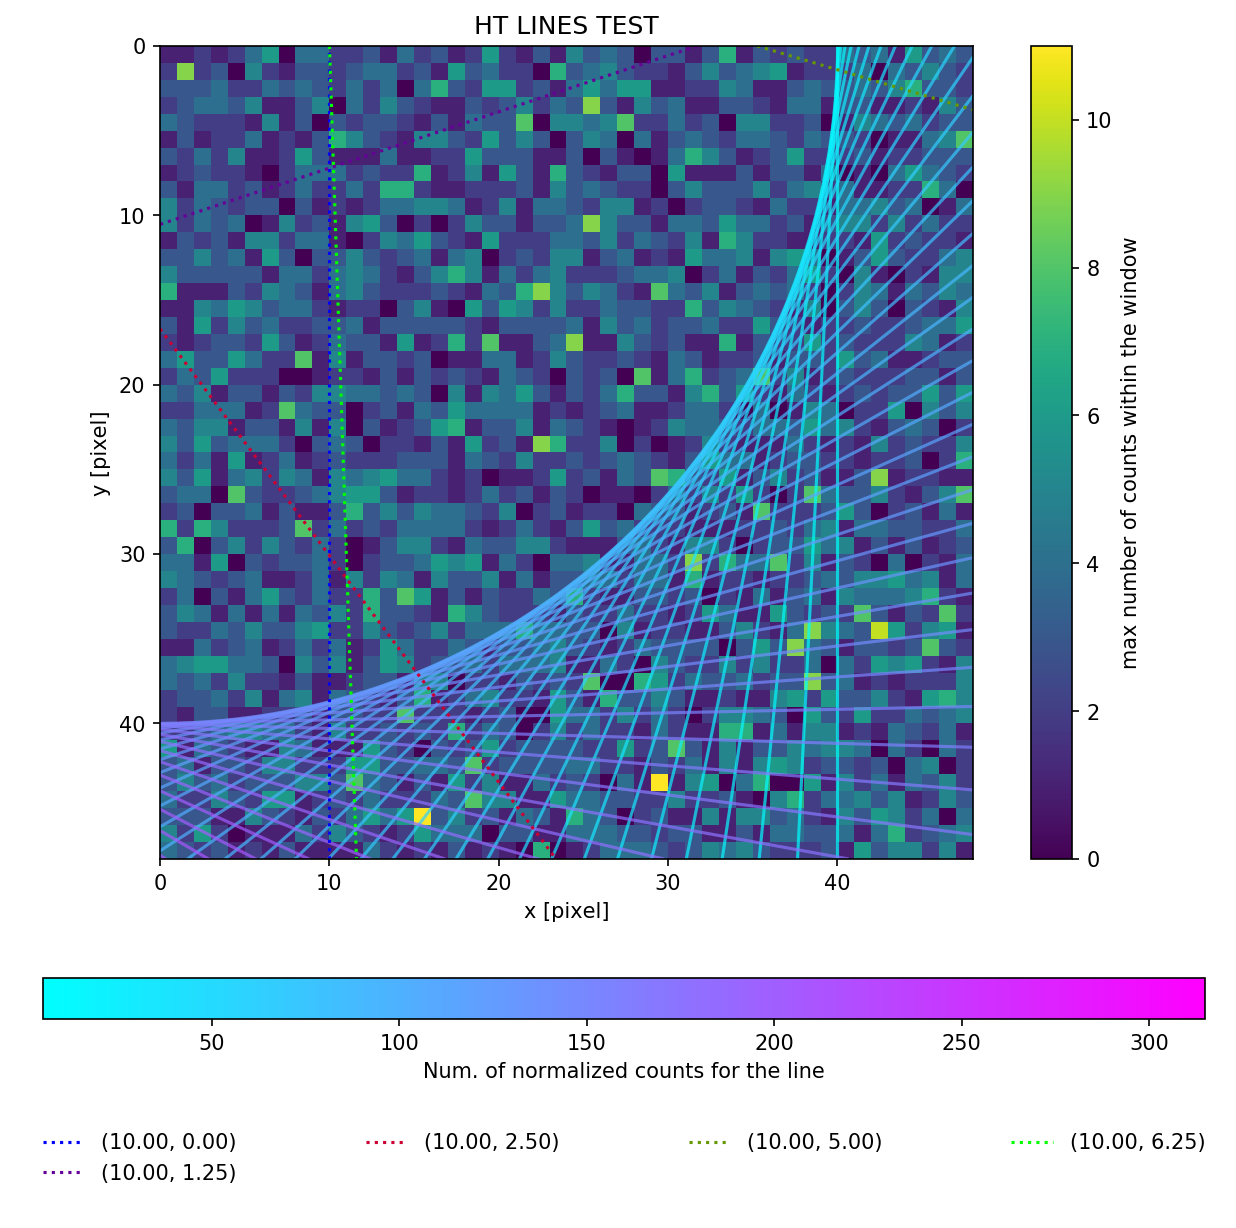

In [389]:
lines = [ (40,i) for i in np.arange(0,np.pi+.05,.05) ] # range(0,49)  # (10,np.pi/150),  (20,np.pi/3),
value_lines_groups = dict([ (i*5, [l] ) for i,l in enumerate(lines) ]) #{ 5:[lines[0]], 8:[lines[1], lines[2i]] }
extra_lines = [ (10,i) for i in np.arange(0,2*np.pi+.25,1.25) ] # range(0,49)  # (10,np.pi/150),  (20,np.pi/3),
# print(value_lines_groups)
f, (ax4, ax5) = visualize_hough_lines(im, lines, "HT LINES TEST", value_lines_groups, extra_lines=extra_lines, fig_dimensions=(10,10))
plt.show()

In [153]:
[("{}/8".format(p), _rho_cor( np.pi*p/8 )) for p in range(0,32)]

[('0/8', 0.5),
 ('1/8', 0.54119610014619701),
 ('2/8', 0.70710678118654757),
 ('3/8', 0.54119610014619701),
 ('4/8', 0.5),
 ('5/8', 0.54119610014619701),
 ('6/8', 0.70710678118654757),
 ('7/8', 0.54119610014619701),
 ('8/8', 0.5),
 ('9/8', 0.5411961001461969),
 ('10/8', 0.70710678118654757),
 ('11/8', 0.54119610014619712),
 ('12/8', 0.5),
 ('13/8', 0.54119610014619701),
 ('14/8', 0.70710678118654768),
 ('15/8', 0.54119610014619712),
 ('16/8', 0.5),
 ('17/8', 0.54119610014619701),
 ('18/8', 0.70710678118654768),
 ('19/8', 0.54119610014619712),
 ('20/8', 0.5),
 ('21/8', 0.54119610014619701),
 ('22/8', 0.70710678118654668),
 ('23/8', 0.54119610014619723),
 ('24/8', 0.5),
 ('25/8', 0.54119610014619701),
 ('26/8', 0.70710678118654713),
 ('27/8', 0.54119610014619723),
 ('28/8', 0.5),
 ('29/8', 0.54119610014619701),
 ('30/8', 0.70710678118654657),
 ('31/8', 0.54119610014619723)]

In [123]:
x=np.linspace(0.,10.,15)
y=np.linspace(5,45,15)

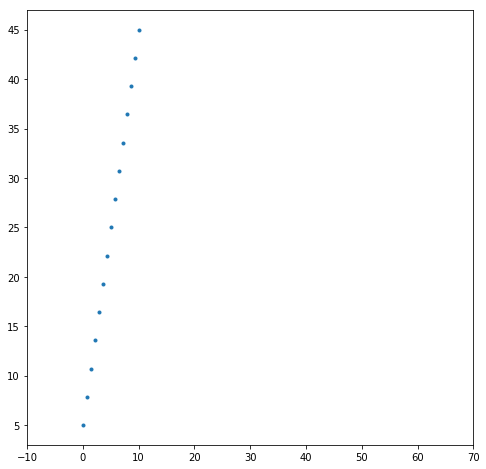

In [408]:
axes_lim = ((-5,15),(-10,70))
fig, ax = plt.subplots(1)
plt.plot(x,y,'.')
ax.set_xlim(*axes_lim[0])
ax.set_xlim(*axes_lim[1])
fig.set_size_inches(8,8)
plt.show()

In [115]:
def find_minimal_rectangle(cluster_im):
    first_row = -1
    first_col = -1
    last_row = -1
    last_col = -1
    for i, j in itertools.product(range(cluster_im.shape[0]), range(cluster_im.shape[1])):
        if cluster_im[i, j]:
            if first_row < 0:
                first_row = i
            last_row = i
            if first_col < 0 or j < first_col:
                first_col = j
            if last_col < 0 or j > last_col:
                last_col = j

    if last_row < 0:
        raise EmptyDataError()

    # if not (first_row >= 0 and last_row >=0 and first_col >= 0 and last_col >= 0):
    #     print(cluster_im.shape)
    #     print (first_row, last_row, first_col, last_col)
    # assert first_row >= 0 and last_row >=0 and first_col >= 0 and last_col >= 0
    return (first_row, last_row), (first_col, last_col)

def find_minimal_dimensions(cluster_im):
    p1, p2 = find_minimal_rectangle(cluster_im)
    first_row, last_row = p1
    first_col, last_col = p2
    return (last_row-first_row+1, last_col-first_col+1)

In [173]:
def find_minimal_rectangle_numpy(cluster_im, wrapover_x=False):
    rows = np.any(cluster_im, axis=1)
    cols = np.any(cluster_im, axis=0)
    true_rows = np.where(rows)[0]
    true_cols = np.where(cols)[0]
    if len(true_cols) == 0:
        raise EmptyDataError()
    first_row, last_row = true_rows[[0, -1]]
    first_col, last_col = true_cols[[0, -1]]
    
    if wrapover_x:
        max_col_gap = len(cols) - 1 - last_col + first_col
        gap_start_col = first_col+1
        for i in range(first_col+1,last_col):
            if cols[i-1] and not cols[i]:
                gap_start_col = i
            elif not cols[i-1] and cols[i]:
                gap_len = i - gap_start_col
#                 print("cols[{}]={} : gap_len={}".format(i,cols[i],gap_len))
                if gap_len > max_col_gap:
                    max_col_gap = gap_len
                    last_col = gap_start_col-1
                    first_col = -(len(cols)-i)
#                     print("\tmax_col_gap={}\n\tlast_col={}\n\tfirst_col={}".format(max_col_gap, last_col, first_col))
    
    return first_row, last_row, first_col, last_col

def find_minimal_dimensions_numpy(cluster_im, wrapover_x=False):
    first_row, last_row, first_col, last_col = find_minimal_rectangle_numpy(cluster_im,wrapover_x)
    return (last_row-first_row+1, last_col-first_col+1)

In [174]:
b = np.zeros((10,10))
b[3:7,3+1:7+1] = 3

In [175]:
b

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  3.,  3.,  3.,  3.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [176]:
find_minimal_rectangle_numpy(b)

(3, 6, 4, 7)

In [177]:
find_minimal_dimensions_numpy(b)

(4, 4)

In [178]:
find_minimal_dimensions(b)

(4, 4)

In [179]:
cols = np.any(b, axis=0)
true_cols = np.where(cols)[0]

In [180]:
cols, true_cols

(array([False, False, False, False,  True,  True,  True,  True, False, False], dtype=bool),
 array([4, 5, 6, 7]))

In [186]:
a = np.zeros((10,10))
a[3:7,0:2] = 1
a[3:7,-2:] = 2
a[3:7,3] = 3
a[3:7,4] = 4
a[3:7,6] = 6

In [187]:
a

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  0.,  3.,  4.,  0.,  6.,  0.,  2.,  2.],
       [ 1.,  1.,  0.,  3.,  4.,  0.,  6.,  0.,  2.,  2.],
       [ 1.,  1.,  0.,  3.,  4.,  0.,  6.,  0.,  2.,  2.],
       [ 1.,  1.,  0.,  3.,  4.,  0.,  6.,  0.,  2.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [188]:
cols = np.any(a, axis=0)
true_cols = np.where(cols)[0]

In [189]:
cols, true_cols

(array([ True,  True, False,  True,  True, False,  True, False,  True,  True], dtype=bool),
 array([0, 1, 3, 4, 6, 8, 9]))

In [190]:
find_minimal_rectangle_numpy(a,True), find_minimal_dimensions_numpy(a,True)

((3, 6, -7, 1), (4, 9))

In [171]:
first_col, last_col = true_cols[[0, -1]]
len(cols) - 1 - last_col + first_col

0

In [172]:
first_col, last_col = true_cols[[0, -1]]

max_col_gap = len(cols) - 1 - last_col + first_col
gap_start_col = first_col+1
for i in range(first_col+1,last_col):
    if cols[i-1] and not cols[i]:
        gap_start_col = i
    elif not cols[i-1] and cols[i]:
        gap_len = i - gap_start_col
        print("cols[{}]={} : gap_len={}".format(i,cols[i],gap_len))
        if gap_len > max_col_gap:
            max_col_gap = gap_len
            last_col = gap_start_col-1
            first_col = -(len(cols)-i)
            print("\tmax_col_gap={}\n\tlast_col={}\n\tfirst_col={}".format(max_col_gap, last_col, first_col))

cols[6]=True : gap_len=4
	max_col_gap=4
	last_col=1
	first_col=-4
cols[8]=True : gap_len=1


In [ ]:
max_col_gap = len(cols) - 1 - true_cols[-1] + true_cols[0]
box_limits  = true_cols[-1], true_cols[1]
gap_start_col=-1 #true_cols[0]
gap_len = 0
for i in range(true_cols[0]+1,true_cols[-1]):
    # i > 0 and
    if cols[i-1] and not cols[i]:
        gap_start_col = i
    elif cols[i]:
        gap_len = i - gap_start_col
        if gap_len > max_col_gap:
            max_col_gap = gap_len
            box_limits = true_cols[0], -(len(cols)-i)

w = box_limits[0] - box_limits[1] + 1


In [82]:
t0 = time.time()
for i in range(10000):
    ta = np.zeros((100,100))
    ta[3:7,3+1:7+1] = np.random.randint(5, size=(4,4))
    find_minimal_dimensions(ta)
print("dt =",time.time()-t0)
t0 = time.time()
for i in range(10000):
    ta = np.zeros((100,100))
    ta[3:7,3+1:7+1] = np.random.randint(5, size=(4,4))
    find_minimal_dimensions_numpy(ta)
print("dt =",time.time()-t0)

dt = 16.559082984924316
dt = 0.45488858222961426
